## Experiment 1 (section 6.2)
Edible brown and inedible red mushrooms training with a custom model


In [2]:
import os
import random
from pathlib import Path
import re
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import numpy as np
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import zipfile
import shutil
import sklearn

now = datetime.now()

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
os.mkdir('raw')

In [ ]:
zippath='../../datasets/exp1.zip'
with zipfile.ZipFile(zippath, 'r') as zip_ref:
    zip_ref.extractall('raw')

We are splitting the data to three subsets: training, validation and test datasets.

The ratio we established to be the best is 60/20/20.

In [ ]:
import os
from shutil import copyfile
from pathlib import Path
import re
import pandas as pd
from tqdm import tqdm

import random
def split_data(SOURCE, TRAINING, VALID, TESTING, splitsizetrain, splitsizevalid, splitsizetest):
    files = []

    os.mkdir(TRAINING)
    os.mkdir(VALID)
    os.mkdir(TESTING)


    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * splitsizetrain)
    valid_length = int(len(files) * 0.8)
    #testing_length = int(len(files) - valid_length)
    #print(training_length, valid_length, testing_length)
    shuffled_set = random.sample(files, len(files))

    training_set = shuffled_set[:training_length]

    testing_set = shuffled_set[training_length:valid_length]
    #print(training_length,valid_length)
    valid_set = shuffled_set[valid_length:]


    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)    

p = Path('./raw')
print(p)
folders = [x for x in p.iterdir() if x.is_dir()]
split_size_train = .6
split_size_valid = .2
split_size_test = .2

try:
  os.mkdir('tmp')
except:
  print('error')

try:  
  os.mkdir('tmp/train')
  os.mkdir('tmp/valid')
  os.mkdir('tmp/test')
except:
  print('error but here')  

for f in tqdm(folders):
    z = Path(f)
    source = './'+str(z)+'/'

    split_data(source, './tmp/train/'+z.parts[1]+'/', './tmp/valid/'+z.parts[1]+'/',
                './tmp/test/'+z.parts[1]+'/',split_size_train, split_size_valid, split_size_test)
    



raw


100%|██████████| 2/2 [00:08<00:00,  4.04s/it]


We define our custom model, we found inspiration from the old LeNet, and build upon it accoriding to our needs and data.

In [ ]:


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),

    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    #tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    #tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


Just plain loading the dataset from the folders.

We augument the training portion of the dataset with a couple of operations, so we have a slightly bigger dataset.

Important operation is to set the Testing dataset to not be shuffled, for we are using it later to make classification reports.

We are using a batchsize of 128 because there is fairly not that many images in both of our classes, so it shouldnt pose a problem.

In [ ]:
BATCHSIZE = 128
TRAINING_DIR = "./tmp/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255., 
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=BATCHSIZE,
                                                    class_mode='binary',
                                                    target_size=(224, 224))

VALIDATION_DIR = "./tmp/valid/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=BATCHSIZE,
                                                              class_mode='binary',
                                                              target_size=(224, 224))

TESTING_DIR = "./tmp/test/"
test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                              batch_size=BATCHSIZE,
                                                              shuffle=False,
                                                              class_mode='binary',
                                                              target_size=(224, 224))
4680
print(len(train_generator.classes))
print(len(validation_generator.classes))
print(len(test_generator.classes))

Found 2807 images belonging to 2 classes.
Found 937 images belonging to 2 classes.
Found 936 images belonging to 2 classes.
2807
937
936


We are defining some operations that help us during training process, such as automatic stopping of training, automatic LR decreasing, model saving and Tensorboard, that comes with accuracy/loss scalars logs, and we also log the confusion matrix after each epoch into Tensorboard.

In [ ]:
import itertools 
import seaborn as sb
from sklearn.metrics import precision_recall_curve
!rm -rf ./logs/ 
def plot_confusion_matrix(cm): 
    ax = plt.subplot()

    groupnames = ['True Edible','False Inedible','False Edible','True Inedible']
    #labels = np.asarray(labels).reshape(2,2)
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(groupnames,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    sb.heatmap(cm, annot=labels, fmt='', ax=ax, cmap='Purples')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Edible', 'Inedible'])
    ax.yaxis.set_ticklabels(['Edible', 'Inedible'])

    result = ax.get_figure()


    #print(result)
    return result


from io import BytesIO
def plot_to_image(figure):   
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=200)
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)  
    image = tf.expand_dims(image, 0)    
    return image    

from sklearn import metrics

def log_confusion_matrix(epoch, logs):
    test_generator.reset()
    predictions = model.predict(test_generator)
    precision, recall, thresholds = precision_recall_curve(test_generator.classes, predictions)

    # get f-score
    fscore = (2 * precision * recall) / (precision + recall)

    # get the position of highest fscore
    i = np.argmax(fscore)
    #print('Best Threshold=%f, F-Score=%.3f' % (thresholds[i], fscore[i]))

    best_threshold = thresholds[i]

    predictions[predictions >= best_threshold] = 1
    predictions[predictions < best_threshold] = 0

    cm = metrics.confusion_matrix(test_generator.classes, predictions)
    
    figure = plot_confusion_matrix(cm)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)   


from datetime import datetime

logsdir = 'logs/scalars'
file_writer_cm = tf.summary.create_file_writer(logsdir)
from keras.callbacks import ModelCheckpoint, TensorBoard, LambdaCallback, EarlyStopping, ReduceLROnPlateau



callbacks = [
             TensorBoard(log_dir=logsdir, 
               #histogram_freq=1, 
               #write_graph=True,
               #write_images=True,
               #update_freq='epoch',
               #profile_batch=2,
               #embeddings_freq=1
              ),
    LambdaCallback(on_epoch_end=log_confusion_matrix),
    ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1,mode='auto', period=1),
    EarlyStopping(monitor='val_accuracy', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2, verbose=1)

]

In [ ]:
%tensorboard --logdir {logsdir}

As our dataset is not balanced, we need to find out the balance of weights between them.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
cw = dict(zip( np.unique(train_generator.classes), weights))
print(cw)

{0: 0.8827044025157232, 1: 1.1532456861133935}


We may begin the training process now.

In [ ]:
history = model.fit(train_generator, epochs=100, 
                    validation_data=validation_generator, class_weight=cw, callbacks=[callbacks])

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 2.0940 - accuracy: 0.4471
Epoch 00001: saving model to drive/MyDrive/bp/final_files/exp1/best_model.hdf5
22/22 [==============================] - 116s 4s/step - loss: 2.0940 - accuracy: 0.4471 - val_loss: 0.6934 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4336
Epoch 00002: saving model to drive/MyDrive/bp/final_files/exp1/best_model.hdf5
22/22 [==============================] - 83s 4s/step - loss: 0.6932 - accuracy: 0.4336 - val_loss: 0.6935 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.4389
Epoch 00003: saving model to drive/MyDrive/bp/final_files/exp1/best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
22/22 [==============================] - 83s 4s/step - loss: 0.6931 - accuracy: 0.4389 - val_loss: 1.7503 - val

After finished training, we log important information and we also save the model, for future use.

In [ ]:
import pickle


with open('history_'+str(now)+'.bytes', 'wb') as f:
  pickle.dump(history.history, f)

In [ ]:

tf.keras.models.save_model(
    model,
    'final_exp1_'+str(now) +'.hdf5'
)

Now we need to find out how our model did, so we retrieve the predictions for the test dataset.

In [ ]:
test_generator.reset()
predictions = model.predict(test_generator)

We calculate the best threshold and f-score for our current trained model.

Best Threshold=0.314343, F-Score=0.847


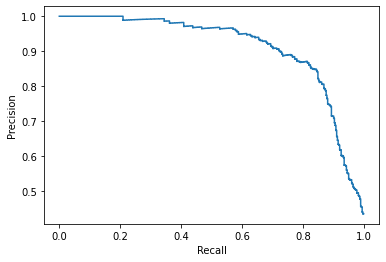

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(test_generator.classes, predictions)



# get f-score
fscore = (2 * precision * recall) / (precision + recall)

# get the position of highest fscore
i = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[i], fscore[i]))

best_threshold = thresholds[i]

display = PrecisionRecallDisplay(precision, recall)
display.plot()
plt.savefig('savedPR_'+str(now)+'.png', dpi=200)


Now, we create the confusion matrix, print out the classification report and compute the MCC.

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       530
           1       0.85      0.84      0.85       406

    accuracy                           0.87       936
   macro avg       0.87      0.86      0.87       936
weighted avg       0.87      0.87      0.87       936

0.7301609221472447


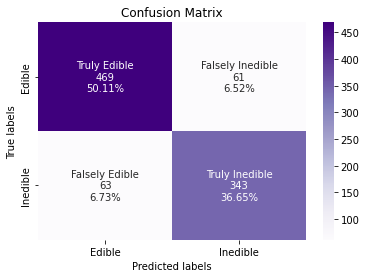

In [ ]:
from sklearn.metrics import matthews_corrcoef

predictions[predictions >= best_threshold] = 1
predictions[predictions < best_threshold] = 0 

cm = metrics.confusion_matrix(test_generator.classes, predictions)
  
ax = plt.subplot()

groupnames = ['Truly Edible','Falsely Inedible','Falsely Edible','Truly Inedible']
#labels = np.asarray(labels).reshape(2,2)
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(groupnames,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sb.heatmap(cm, annot=labels, fmt='', ax=ax, cmap='Purples')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Edible', 'Inedible'])
ax.yaxis.set_ticklabels(['Edible', 'Inedible'])

result = ax.get_figure()

result.savefig('cm_'+str(now)+'.png', dpi=200)


print(metrics.classification_report(test_generator.classes, predictions))
print(matthews_corrcoef(test_generator.classes, predictions))

In [ ]:
model.evaluate(train_generator)

22/22 [==============================] - 61s 3s/step - loss: 0.3676 - accuracy: 0.8522


[0.3676048219203949, 0.852155327796936]

In [ ]:
model.evaluate(validation_generator)

8/8 [==============================] - 11s 1s/step - loss: 0.3669 - accuracy: 0.8527


[0.3669338822364807, 0.8527214527130127]

In [ ]:
model.evaluate(test_generator)

8/8 [==============================] - 11s 1s/step - loss: 0.3704 - accuracy: 0.8547


[0.37035495042800903, 0.8547008633613586]

As we can see our model performs quite well.

As the last thing, we log the plots for some important metrics.

<Figure size 432x288 with 0 Axes>

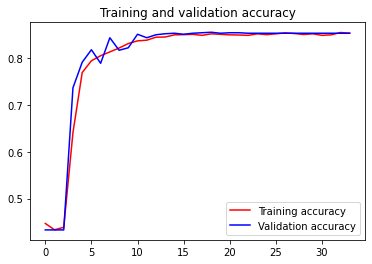

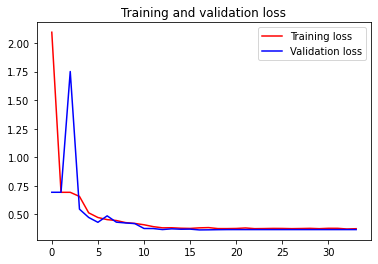

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('acc_'+str(now)+'.png', dpi=200)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss_'+str(now)+'.png', dpi=200)
plt.figure()


But, as we mentioned, the model is not ready for some edge cases, such as slight tint in the image, maybe some colorful spots. Also an inedible brown mushroom is being reported as edible.

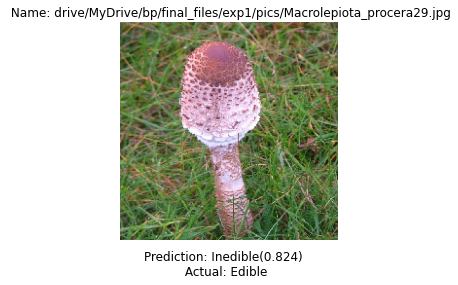

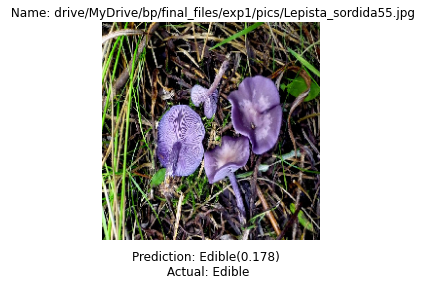

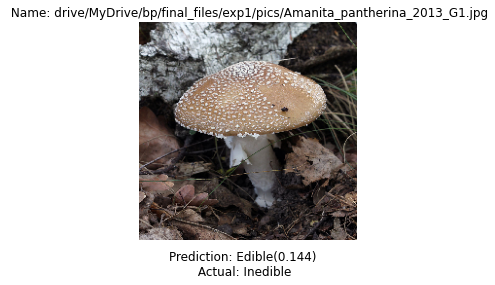

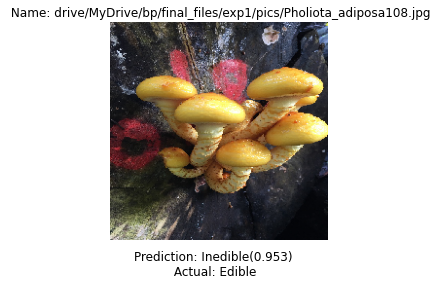

<Figure size 432x288 with 0 Axes>

In [ ]:
pics = ['pics/Macrolepiota_procera29.jpg',
        'pics/Lepista_sordida55.jpg',
        'pics/Amanita_pantherina_2013_G1.jpg',
        'pics/Pholiota_adiposa108.jpg']
        
plt.axis('off')
for r in pics:
    if r == 'pics/Amanita_pantherina_2013_G1.jpg':
      edible = 'Inedible'
    else:
       edible = 'Edible'  
    img = tf.keras.utils.load_img(r, target_size=(224, 224,3))
    img = tf.keras.utils.img_to_array(img)
    img = img/255
    plt.imshow(img)
    
    classes = model.predict(img.reshape(1,224,224,3))
    prediction = 'Inedible' if classes[0][0] > 0.5 else 'Edible'

    txt="Prediction: "+ prediction + '(' + str(round(classes[0][0], 3)) + ')' +  '\n Actual: '+ str(edible)
    plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.axis('off')
    
    plt.title(" Name: " + str(r))
    plt.savefig( str(r)+'.png', dpi=200)
    plt.figure()